In [111]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
from helper import *

%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
plt.style.use('presentation.mplstyle')
logging.getLogger().setLevel(logging.WARNING)

all_analysis_folders = get_analysis_folders()

plate_select = [792,1014,1042,127,130,1023,1045,1053,1048,52,84,938,1076,94,152,102,76,3,12,16,480,91,799,800] #C2
plates += ['1014_20220525', '1023_20220502',
          # '102_20201226',
          '1042_20220523',
       '1045_20220504', '1048_20220506',
          # '1053_20220413',
          '1076_20220511',
       # '127_20220705',
          # '152_20201224',
          "3_20220426", "12_20220502","16_20220419","480_20221205", '52_20220707',
          # '76_20210108',
       # '792_20210915', '799_20211001', '800_20210928',
          '84_20220621', '91_20220708', '938_20220325',
          # '94_20201123'
         ]
plates += ["28_20230227",
"206_20230303",
"202_20230314",
"218_20230227",
"219_20230307",
"229_20230330",]
# plates += [
# "850_20230511",
# "840_20230404",
# "861_20230411"
# ]
plates += ["527_20230106","537_20230111"]
plates += ["462_20221013"]
plates += ["532_20220104"]
plates += [
"249_20230324",
"241_20230403",
"252_20230316",
"248_20230320",
]
plates = ['464_20230807','474_20230807','470_20230709']

plates += ['439_20230804','420_20230705','416_20230705']
plates += ['443_20230720','436_20230717']
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,False)
# folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders,False)
# folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders,False)

In [113]:
timestep = {32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 65,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:150,152:35,792:60,1048:60,1045:50,941:50}
timestep2 = {102:25,83:70,76:20,81:70,32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 75,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:100,152:35,792:50,1048:60,1045:50}
timestep = {**timestep, **timestep2}
timestep2 = {1014 : 80,1024:25,1027:18,1028:60,1030 : 60,1032 : 50,1042 : 120,1048:70,127:120,129:60,130:50,991:40}
timestep = {**timestep, **timestep2}
timestep2 = {1023 : 60,1031:30,1035:30,1037 : 80,1039 : 90,1045:70,1047:50,1053:40}
timestep = {**timestep, **timestep2}    

timestep2 = {1071 : 25,1076:70,839:60,938 : 35}
timestep = {**timestep, **timestep2}
timestep2 = {30 : 62,32 : 160,33:80}
timestep = {**timestep, **timestep2}
timestep2 = {799 : 100,800 : 25,91:100,99:40}
timestep = {**timestep, **timestep2}
timestep2 = {3:144,16 : 39, 12:70,480:150,28 : 100}
timestep = {**timestep, **timestep2}
timestep2 = {3:144,16 : 39, 12:70,480:150,28 : 100,206 : 90,202 : 100,218 : 100,219 :100,229 :100}
timestep = {**timestep, **timestep2}
timestep2 = {850:100,840:100,861:100}
timestep = {**timestep, **timestep2}
timestep2 = {462:100,532:100}
timestep = {**timestep, **timestep2}
timestep2 = {527:100,537:100,558:100}
timestep = {**timestep, **timestep2}
timestep2 = {464:100,474:100,470:100}
timestep = {**timestep, **timestep2}
timestep2 = {249:100,241:100,252:100,248:100}
timestep = {**timestep, **timestep2}
timestep2 = {439:100,443:100,436:100,420:100,416:100}
timestep = {**timestep, **timestep2}

In [114]:
ncols = 3

time_plate_info = time_plate_info.replace(-1.0,np.nan)

# fig,axs = gridplot(len(plates)+1,ncols = ncols,subh = 3,subw = 3)
# ax_list = list(axs)
plate_speeds = {}
for j in range(0,len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    # ax = ax_list[j]
    hull_speeds = []
    hull_time = []
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)]
    time_plate_info_plate = time_plate_info_plate.loc[time_plate_info_plate['timestep']<timestep[plate]]
    # ax.plot(time_plate_info_plate['time_since_begin_h'],time_plate_info_plate['hull_speed'],
    #                 color="black")
    # ax.set_title(plate_id)
    plate_speeds[plate_id] = np.nanmedian(time_plate_info_plate['hull_speed'])

In [115]:
time_plate_info["density"] = time_plate_info["tot_length_study"]/time_plate_info["area_sep_comp"]
time_plate_info["density_biovolume"] = time_plate_info["tot_biovolume_study"]/time_plate_info["area_sep_comp"]
time_plate_info["density_SA"] = time_plate_info["tot_surface_area_study"]/time_plate_info["area_sep_comp"]



In [31]:
folders[folders['unique_id']==46420230807]['fungalC']

3390          None
3391          None
3392          None
3393          None
3394          None
           ...    
3461    '000P100N'
3462    '000P100N'
3463    '000P100N'
3464    '000P100N'
3465    '000P100N'
Name: fungalC, Length: 76, dtype: object

In [116]:
time_plate_info = time_plate_info.replace(-1.0,np.nan)

# fig,axs = gridplot(len(plates)+1,ncols = ncols,subh = 3,subw = 3)
# ax_list = list(axs)
plate_density = {}
plate_density_biov = {}
plate_radius = {}
plate_radius_SA = {}

plate_SA_density = {}

fungalC = {}

plate_strain = {}
plate_start = {}
root = {}
for j in range(0,len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    # ax = ax_list[j]
    hull_speeds = []
    hull_time = []
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)]
    folders_plate = folders.loc[folders['unique_id']==int(plate_id)]
    time_plate_info_plate = time_plate_info_plate.loc[time_plate_info_plate['timestep']<timestep[plate]]
    # ax.plot(time_plate_info_plate['time_since_begin_h'],np.sqrt(time_plate_info_plate['density']),
    #                 color="black")
    # ax2 = ax.twinx()
    # ax2.plot(time_plate_info_plate['time_since_begin_h'],time_plate_info_plate['density']/time_plate_info_plate['density_biovolume'],
    #                 color="red")
    time_plate_info_plate_median = time_plate_info_plate.loc[time_plate_info_plate['timestep']>=min(max(time_plate_info_plate['timestep']),timestep[plate]-10)]

    plate_density[plate_id] = np.nanmedian(time_plate_info_plate_median['density'])
    plate_density_biov[plate_id] = np.nanmedian(time_plate_info_plate_median['density_biovolume']) 
    plate_radius[plate_id] = np.nanmedian(np.sqrt(time_plate_info_plate_median['density_biovolume']/time_plate_info_plate_median['density']/np.pi)) 
    plate_radius_SA[plate_id] = np.nanmedian(time_plate_info_plate_median['density_SA']/time_plate_info_plate_median['density']/(2*np.pi)) 
    
    plate_strain[plate_id] = folders_plate['strain'].iloc[0]
    plate_start[plate_id] = folders_plate['CrossDate'].iloc[0]
    fungalC[plate_id] = folders_plate['fungalC'].iloc[-1]
    root[plate_id] = folders_plate['root'].iloc[-1]
    
    plate_SA_density[plate_id] = np.nanmedian(time_plate_info_plate_median['density_SA'])
    # ax.set_title(plate_id)
    # break

In [84]:
folders['root'].unique()

array(["'Carrot'", "'CarrotEN'"], dtype=object)

In [117]:
df = pd.DataFrame({
    'plate_id': list(plates),
    'start': [plate_start[x] for x in plates],
    'speed': [plate_speeds[x] for x in plates],
    'density_SA': [plate_SA_density[x] for x in plates],
    'density_BV': [plate_density_biov[x] for x in plates],
    'density_L': [plate_density[x] for x in plates],
    
    'radius': [plate_radius[x] for x in plates],
    'radius_SA': [plate_radius_SA[x] for x in plates],
    
    'strain': [plate_strain[x] for x in plates],
    'fungalC': [fungalC[x] for x in plates],
    'root': [root[x] for x in plates],
    
    
})
df['strain'] = df['strain'].replace("'A5sp3'","'A5'")
df['fungalC'] = df['fungalC'].replace(np.nan,"100P100N")

df['BV_growth_coeff'] = df['speed']**2*df['density_BV']
df['SA_growth_coeff'] = df['speed']**2*df['density_SA']*np.pi
df['L_growth_coeff'] = df['speed']**2*df['density_L']
df['SA_growth_coeff2'] = df['L_growth_coeff'] * df['radius_SA']*2*np.pi
df['density_SA'] = df['density_SA']/1e6
df['density_BV'] = df['density_BV']/1e9
df['density_L'] = df['density_L']/1e3






In [121]:
df = df[df['strain']=="'C2'"]
df.loc[df['plate_id'] == '470_20230709', 'fungalC'] = "'000P100N'"
df.loc[df['fungalC'] == "'000P100N'", 'strain'] = "'C2_0P'"
df.loc[df['start'] >= 20230201, 'root'] = "Carrot_Vasilis"


In [120]:
df.loc[df['start'] >= 20230201]

,plate_id,start,speed,density_SA,density_BV,density_L,radius,radius_SA,strain,fungalC,root,BV_growth_coeff,SA_growth_coeff,L_growth_coeff,SA_growth_coeff2
0,464_20230807,20230807,272.037100,0.011864,0.000015,0.926778,2.278589,2.037413,'C2','000P100N','Carrot',1.118700e+09,2.758295e+09,6.858544e+07,8.779926e+08
1,474_20230807,20230807,289.062711,0.017941,0.000025,1.275592,2.497190,2.238527,'C2','000P100N','Carrot',2.088088e+09,4.709642e+09,1.065849e+08,1.499126e+09
2,470_20230709,20230709,277.234764,0.026526,0.000044,1.622086,2.939261,2.602655,'C2',100P100N,'Carrot',3.383728e+09,6.404949e+09,1.246721e+08,2.038759e+09
3,439_20230804,20230804,265.549306,0.034189,0.000065,1.916619,3.278664,2.839030,'C2',100P100N,'Carrot',4.564254e+09,7.574008e+09,1.351531e+08,2.410882e+09
4,420_20230705,20230705,289.964700,0.018902,0.000030,1.116329,2.917202,2.694791,'C2',100P100N,'Carrot',2.509375e+09,4.992723e+09,9.386046e+07,1.589233e+09
5,416_20230705,20230705,268.279719,0.029622,0.000052,1.697445,3.123837,2.777389,'C2',100P100N,'Carrot',3.745397e+09,6.697887e+09,1.221719e+08,2.132004e+09
6,443_20230720,20230720,267.454225,0.021949,0.000035,1.333476,2.905351,2.619734,'C2',100P100N,'Carrot',2.529481e+09,4.932546e+09,9.538591e+07,1.570078e+09
7,436_20230717,20230717,244.163901,0.035476,0.000051,2.503398,2.546048,2.257917,'C2',100P100N,'Carrot',3.041584e+09,6.644238e+09,1.492426e+08,2.117291e+09


In [124]:
def plot_scatter_with_mean_and_ci(df, x_col, y_col, ax, label=None):
    n_colors = len(df['fungalC'].unique())
    palette = sns.color_palette("Reds", n_colors)
    strain_to_color = dict(zip(df['fungalC'].unique(), palette))
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='fungalC', palette=strain_to_color, ax=ax)
    # sns.regplot(data=df, x=x_col, y=y_col, scatter=False, color="black", ax=ax)

    for strain, color in strain_to_color.items():
        sub_df = df[df['fungalC'] == strain]
        x_mean = sub_df[x_col].mean()
        y_mean = sub_df[y_col].mean()
        x_ci = 2 * sub_df[x_col].std()/np.sqrt(len(sub_df))
        y_ci = 2 * sub_df[y_col].std()/np.sqrt(len(sub_df))
        ax.errorbar(x=x_mean, y=y_mean, xerr=x_ci, yerr=y_ci, color=color, fmt='o')

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if label:
        ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')

In [122]:
def plot_scatter_with_mean_and_ci(df, x_col, y_col, ax, label=None):
    n_colors = len(df['root'].unique())
    palette = sns.color_palette("Reds", n_colors)
    strain_to_color = dict(zip(df['root'].unique(), palette))
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='root', palette=strain_to_color, ax=ax)
    # sns.regplot(data=df, x=x_col, y=y_col, scatter=False, color="black", ax=ax)

    for strain, color in strain_to_color.items():
        sub_df = df[df['root'] == strain]
        x_mean = sub_df[x_col].mean()
        y_mean = sub_df[y_col].mean()
        x_ci = 2 * sub_df[x_col].std()/np.sqrt(len(sub_df))
        y_ci = 2 * sub_df[y_col].std()/np.sqrt(len(sub_df))
        ax.errorbar(x=x_mean, y=y_mean, xerr=x_ci, yerr=y_ci, color=color, fmt='o')

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if label:
        ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')

Text(0, 0.5, '$\\rho_L$ ($mm/mm^2$)')

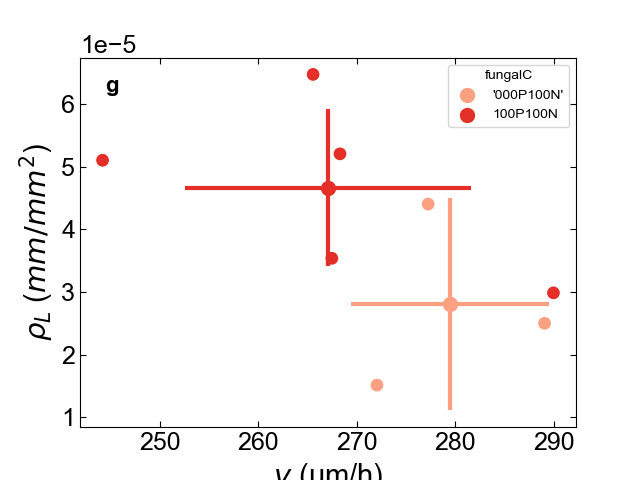

In [125]:
fig,ax = plt.subplots()
(x_col, y_col, label,xlabel,ylabel) =('speed', 'density_BV', 'g', '$v$ (um/h)', r'$\rho_L$ ($mm/mm^2$)')

plot_scatter_with_mean_and_ci(df, x_col, y_col, ax=ax, label=label)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# plt.savefig(os.path.join('figures', '0P100P.pdf'), transparent=True, bbox_inches='tight')


In [56]:

def plot_scatter_with_mean_and_ci(df, x_col, y_col, ax, label=None):
    n_colors = len(df['strain'].unique())
    palette = sns.color_palette("rainbow", n_colors)
    strain_to_color = dict(zip(df['strain'].unique(), palette))
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='strain', palette=strain_to_color, ax=ax)
    sns.regplot(data=df, x=x_col, y=y_col, scatter=False, color="black", ax=ax)

    for strain, color in strain_to_color.items():
        sub_df = df[df['strain'] == strain]
        x_mean = sub_df[x_col].mean()
        y_mean = sub_df[y_col].mean()
        x_ci = 2 * sub_df[x_col].std()
        y_ci = 2 * sub_df[y_col].std()
        ax.errorbar(x=x_mean, y=y_mean, xerr=x_ci, yerr=y_ci, color=color, fmt='o')

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if label:
        ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')
    


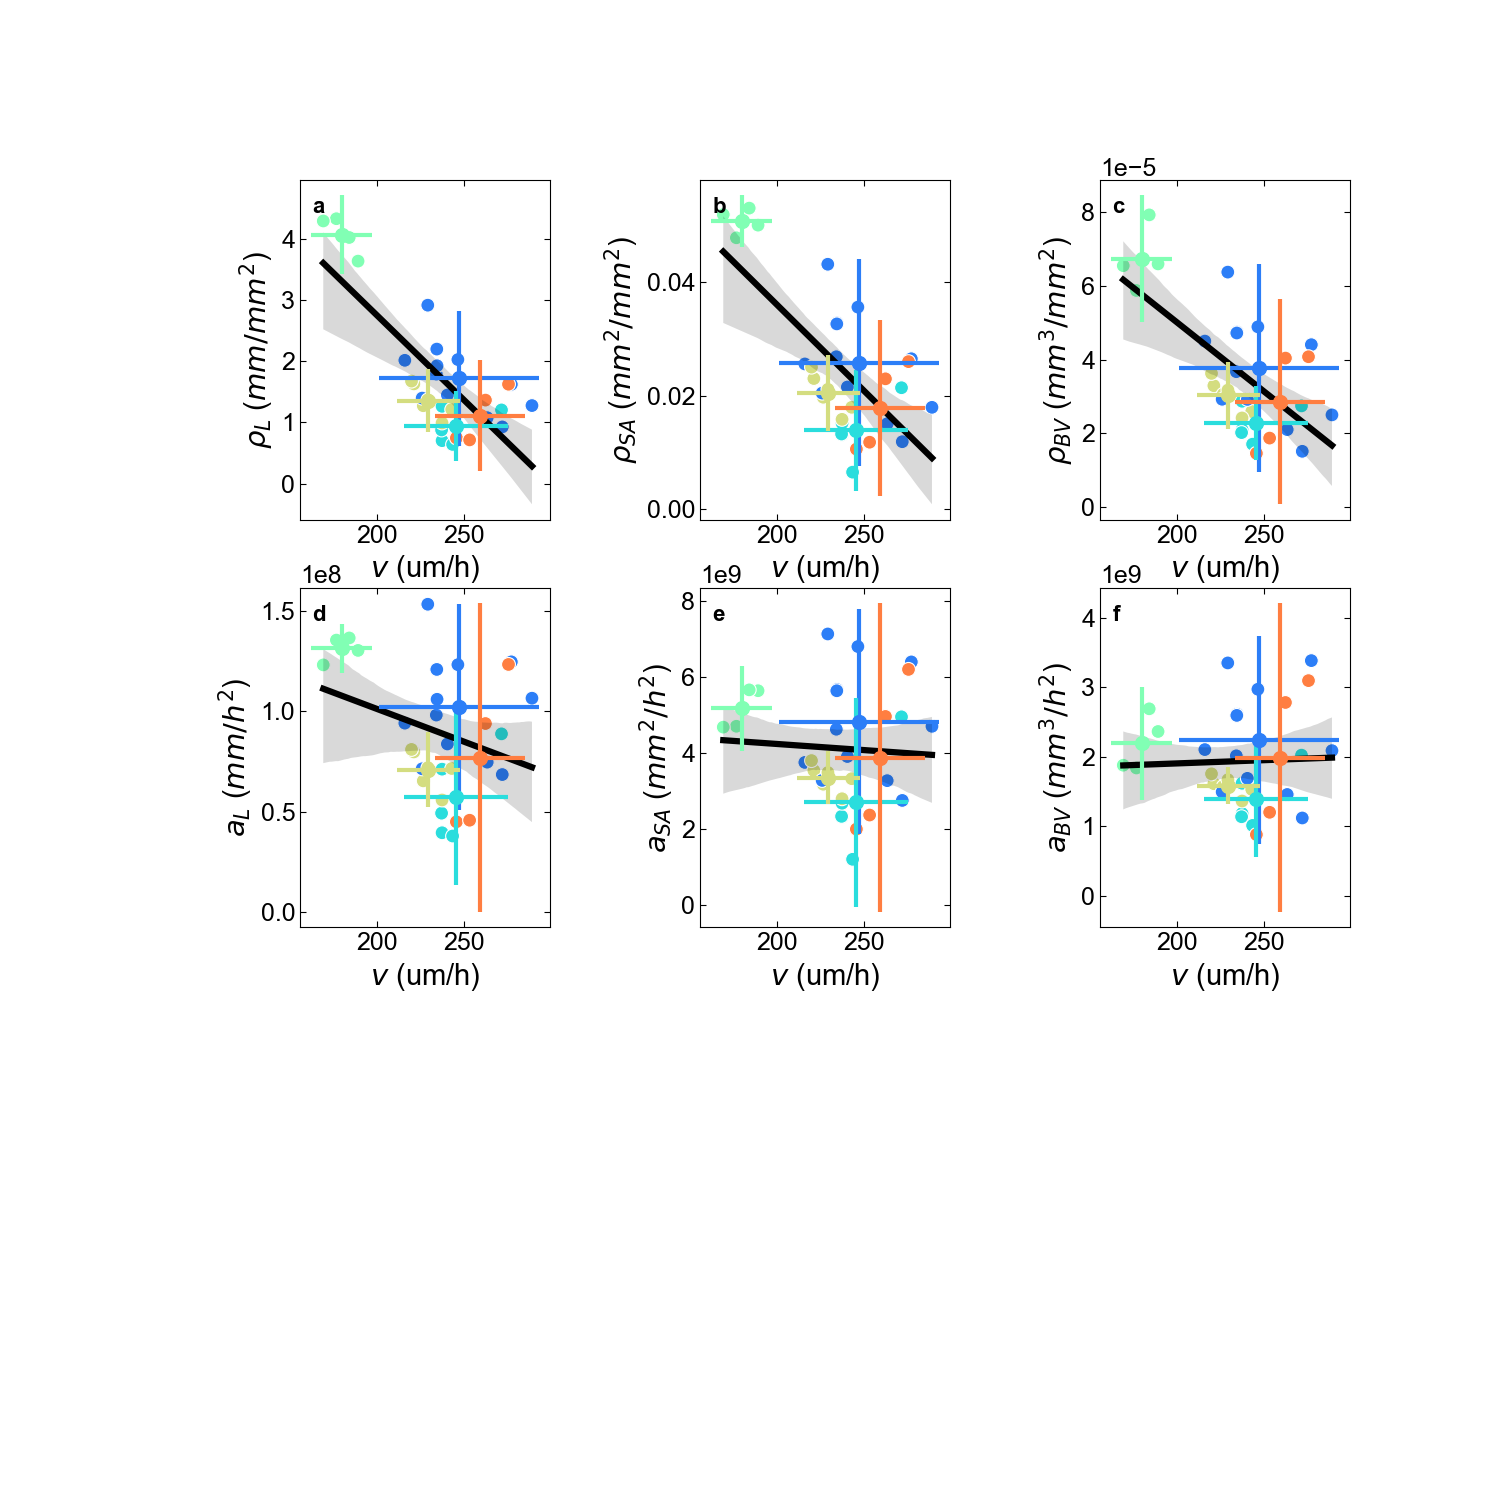

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
plt.subplots_adjust(left=0.2, wspace=0.6)
axes = axes.flatten()  # Flatten the array of axes to easily loop through it

# Assuming `df` is your DataFrame
plots = [
    ('speed', 'density_L', 'a', '$v$ (um/h)', r'$\rho_L$ ($mm/mm^2$)'),
    ('speed', 'density_SA', 'b', '$v$ (um/h)', r'$\rho_{SA}$ ($mm^2/mm^2$)'),
    ('speed', 'density_BV', 'c', '$v$ (um/h)', r'$\rho_{BV}$ ($mm^3/mm^2$)'),
    ('speed', 'L_growth_coeff', 'd', '$v$ (um/h)', '$a_L$ ($mm/h^2$)'),
    ('speed', 'SA_growth_coeff', 'e', '$v$ (um/h)', '$a_{SA}$ ($mm^2/h^2$)'),
    ('speed', 'BV_growth_coeff', 'f', '$v$ (um/h)', '$a_{BV}$ ($mm^3/h^2$)'),
    # ('speed', 'radius', 'g', 'speed (um/h)', 'effective mean radius ($\mu m$)')
]

for i, (x_col, y_col, label,xlabel,ylabel) in enumerate(plots):
    plot_scatter_with_mean_and_ci(df, x_col, y_col, ax=axes[i], label=label)
    axes[i].set_xlabel(xlabel)
    axes[i].set_ylabel(ylabel)
num_plots = len(plots)

# Making the unused subplots invisible
for i in range(num_plots, len(axes)):
    axes[i].axis('off')
for i in range(0,num_plots):
    axes[i].legend().remove()
# plt.savefig(os.path.join('figures', 'AllFigures.pdf'), transparent=True, bbox_inches='tight')
# plt.show()

In [160]:
# Initialize an empty DataFrame to hold the concatenated data
concatenated_data = []

for j in range(0, len(plates)):
    
    plate_id = plates[j]
    if plate_start[plate_id] >= 20220101:
        
        plate = int(plate_id.split('_')[0])
        
        time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id'] == int(plate_id)]
        time_plate_info_plate = time_plate_info_plate.sort_values(by='time_since_begin_h')
        folders_plate = folders.loc[folders['unique_id'] == int(plate_id)]
        time_plate_info_plate = time_plate_info_plate.loc[time_plate_info_plate['timestep'] < timestep[plate]]
        t_shift = time_plate_info_plate[time_plate_info_plate['area_sep_comp'] >= 100]['time_since_begin_h'].iloc[0]
        time_plate_info_plate['time_since_begin_h_shifted'] = time_plate_info_plate['time_since_begin_h'] - t_shift+40
        # Add the strain information to the DataFrame
        time_plate_info_plate['strain'] = plate_strain[plate_id]
        # time_plate_info_plate['is_in'] = time_plate_info_plate['timestep']<timestep[plate]
        
        time_plate_info_plate['strain_unique_id'] = time_plate_info_plate['strain'].astype(str) + '_' + time_plate_info_plate['unique_id'].astype(str)
        # Append this modified DataFrame to a list
        concatenated_data.append(time_plate_info_plate)

# Concatenate all the DataFrames in the list into a single DataFrame
final_data = pd.concat(concatenated_data)

# Replace -1.0 with NaN
final_data = final_data.replace(-1.0, np.nan)


2023-09-19 14:14:02,711-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


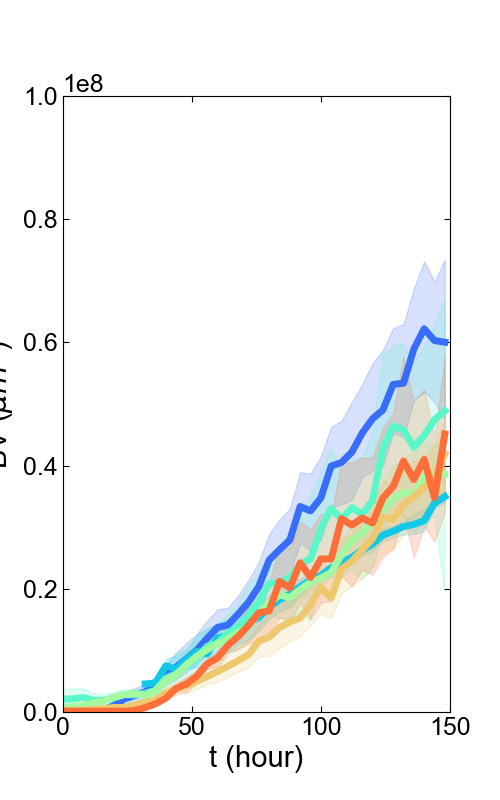

In [165]:
fig,ax = plt.subplots(figsize = (5,8))
n_colors = len(final_data['strain'].unique())
bin_size = 4

final_data['time_hour_binned'] = final_data['time_since_begin_h_shifted'].astype(int)//bin_size*bin_size
tmax = 150
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(select['strain'].unique(), palette))
# sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['tot_biovolume_study'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['tot_biovolume_study'], hue='strain', ax=ax, palette=strain_to_color, estimator='mean', lw=5, ls="-")
ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
ax.set_ylim(0,1e8)
ax.set_xlim(0,tmax)

plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


2023-09-19 14:14:13,109-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


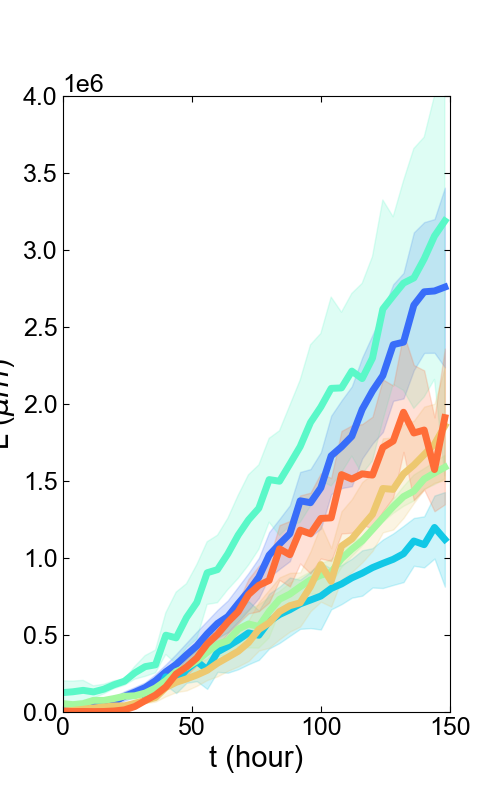

In [166]:
fig,ax = plt.subplots(figsize = (5,8))
n_colors = len(final_data['strain'].unique())
palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(select['strain'].unique(), palette))
# sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['tot_length_study'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['tot_length_study'], hue='strain', ax=ax, palette=strain_to_color, estimator='mean', lw=5, ls="-")
ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('L ($\mu m$)')
ax.set_ylim(0,4e6)
ax.set_xlim(0,tmax)
plt.savefig(os.path.join('figures', 'time_length.pdf'), transparent=True, bbox_inches='tight')


Text(0, 0.5, 'BV ($\\mu m^3$)')

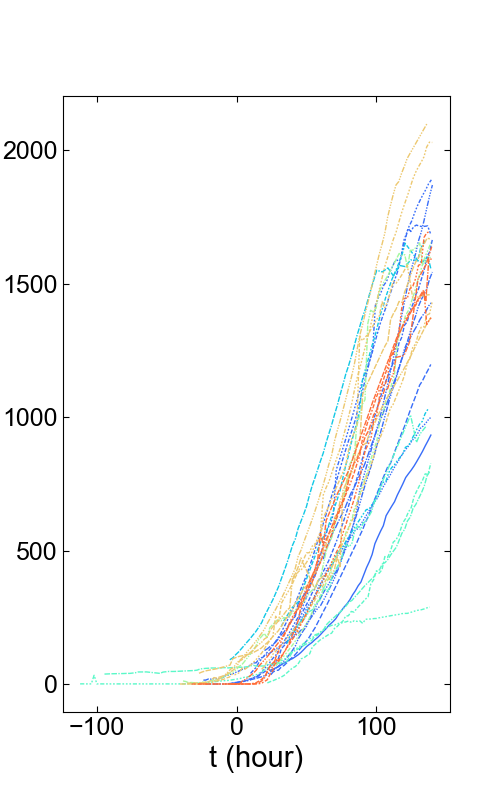

In [159]:
fig,ax = plt.subplots(figsize = (5,8))
n_colors = len(final_data['strain'].unique())
bin_size = 4

final_data['time_hour_binned'] = final_data['time_since_begin_h_shifted'].astype(int)//bin_size*bin_size

select = final_data[final_data['time_since_begin_h_shifted']<=140]
palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(select['strain'].unique(), palette))
sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['area_sep_comp'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
# sns.lineplot(data=select, x='time_hour_binned', y=select['area_sep_comp'], hue='strain', ax=ax, palette=strain_to_color, estimator='mean', lw=5, ls="-")
ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
# ax.set_ylim(0,1e8)
# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


In [41]:
coefficients

array([-0.46871842,  0.43679722])

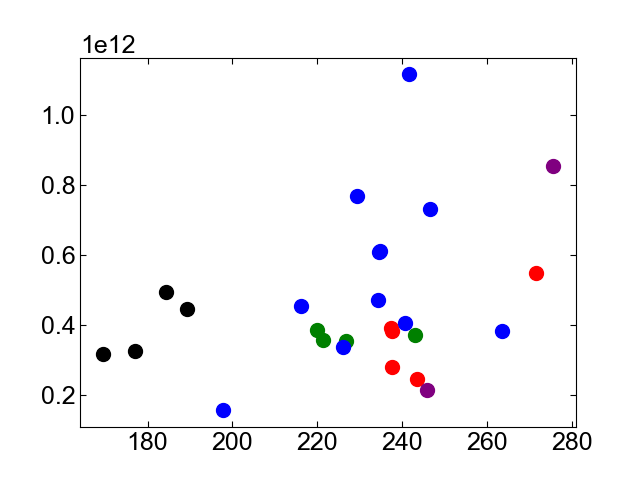

In [21]:
fig,ax = plt.subplots()
for j in range(0,len(plates)):
    plate_id=plates[j]
    if type(plate_start[plate_id]) == int and plate_start[plate_id]>=20220101:
        ax.scatter(plate_speeds[plate_id],plate_density_biov[plate_id]*plate_speeds[plate_id]**3,color = colors[plate_strain[plate_id]])

In [189]:
growth_coefficients = [plate_density_biov[plate_id]*plate_speeds[plate_id]**2 for plate_id in plates]
speeds =  [plate_speeds[plate_id] for plate_id in plates]
densities = [plate_density[plate_id] for plate_id in plates]

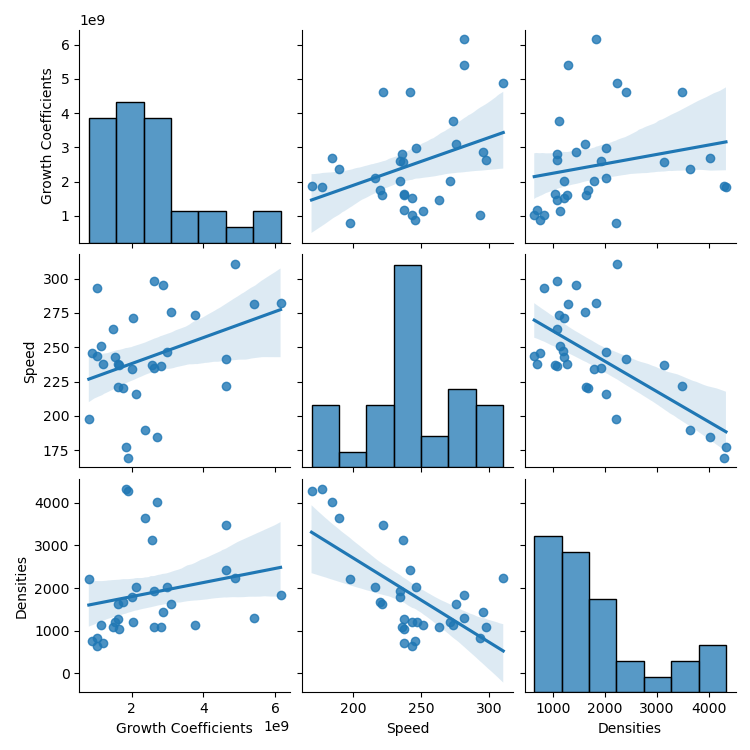

In [191]:
import seaborn as sns
data = pd.DataFrame({'Growth Coefficients': growth_coefficients,
                     'Speed': speeds,
                     'Densities': densities})

# Create the scatter plot matrix with regression lines
sns.pairplot(data, kind='reg')

In [22]:
for plate in plates:
    fig,ax = plt.subplots()
    
    select = time_plate_info.loc[time_plate_info["unique_id"] == int(plate)]
    # Ds[plate] = select["density"].iloc[timestep[int(plate.split('_')[0])]]
    ax.plot(select["timestep"],select["density"])
    ax.set_title(plate)

In [30]:
total = [np.nan]+hull_speeds+[np.nan]*2
len(total)

100

In [42]:
table["hull_speed"]

0      -1.000000
1     225.182090
2     218.162858
3     218.295316
4     206.837753
         ...    
95    254.297396
96    267.683245
97    216.478273
98     -1.000000
99     -1.000000
Name: hull_speed, Length: 100, dtype: float64

In [40]:
table = table.transpose()
table.to_json(path_save)